In [304]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('dji.csv', header=1, usecols=[0,1,2,3,4])

df.head()

,Unnamed: 0,Date,Dow Jones value,RIS Forecast Volume,RIS Actual Volume
0,NaN,1/4/2016,17148.94,6547,6886
1,NaN,1/5/2016,17158.66,4328,4928
2,NaN,1/6/2016,16906.51,3987,3713
3,NaN,1/7/2016,16514.10,4006,3910
4,NaN,1/8/2016,16346.45,4107,3797


In [305]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].max()

Timestamp('2020-08-13 00:00:00')

In [306]:
df = df[['Date','RIS Actual Volume']]

df.columns = ['ds','y']

df = df[df['ds'] >= '2018-07-01']
df.head()

,ds,y
628,2018-07-02,2890
629,2018-07-03,2190
630,2018-07-05,2460
631,2018-07-06,2440
632,2018-07-09,3225


In [307]:
# Python
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [308]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
892,2021-08-09
893,2021-08-10
894,2021-08-11
895,2021-08-12
896,2021-08-13


In [309]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
892,2021-08-09,2745.875843,2282.328293,3209.890324
893,2021-08-10,2192.558313,1709.091557,2695.210017
894,2021-08-11,1989.992547,1524.316935,2463.474245
895,2021-08-12,1892.384862,1377.236704,2348.033903
896,2021-08-13,1976.016948,1505.178060,2464.919120


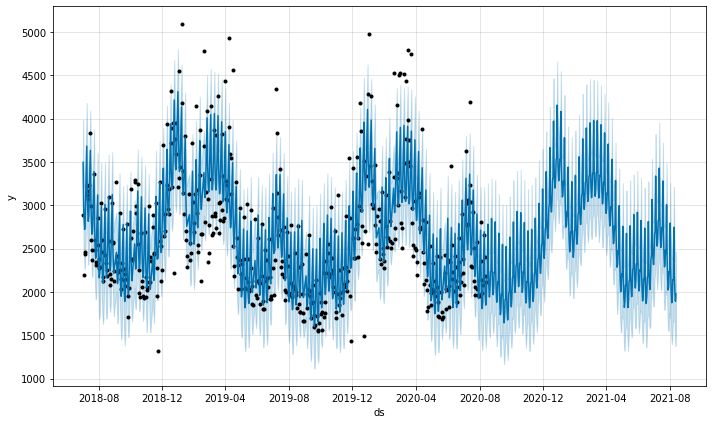

In [310]:
# Python
fig1 = m.plot(forecast)

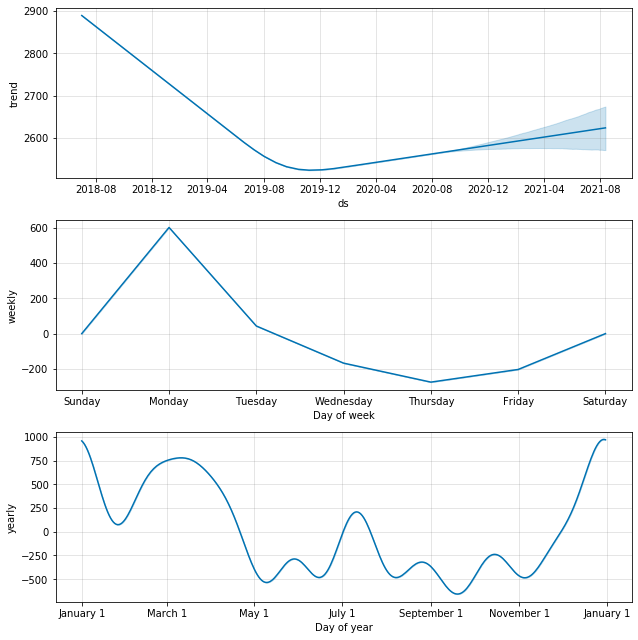

In [311]:
# Python
fig2 = m.plot_components(forecast)

# Calculate MAPE

In [312]:
f = forecast[(forecast['ds']>='2020-08-14') & (forecast['ds']<'2020-08-20')][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

f = f[(f['ds'] != '2020-08-15') & (f['ds'] != '2020-08-16')]

f['actual'] = [1992,2690,2189,2196]

f['forecast'] = [1962,2844,2343,2137]

'prophet',abs((f['yhat']-f['actual'])/f['actual']).mean(), 'erlang',abs((f['forecast'] - f['actual'])/f['actual']).mean()

('prophet', 0.03922814186119733, 'erlang', 0.042382025338796786)

In [313]:
f[['yhat','actual','forecast']]

,yhat,actual,forecast
532,1932.769476,1992,1962
535,2780.853995,2690,2844
536,2235.376790,2189,2343
537,2037.410680,2196,2137
